# Лабораторная работа №4. Интерполяция

In [1]:
import sys
import numpy
import os
import math
import matplotlib
import matplotlib.pyplot as plt

### Сплайны

In [2]:
def MakeDiagonal(A, f):
    for rowIndex in range(len(A)-1, -1, -1):
        columnIndex = rowIndex

        # Уже сделали это в MakeUpDiagonal.
        #f[rowIndex] /= A[rowIndex][columnIndex]
        #A[rowIndex][columnIndex] = 1

        for _rowIndex in range(0, rowIndex):
            f[_rowIndex] -= f[rowIndex] * A[_rowIndex][columnIndex]
            A[_rowIndex][columnIndex] = 0

def MakeUpDiagonal(A, f, findMaxElem):
    for columnIndex in range(0, len(A)):
        rowIndex = columnIndex
        
        # Ищем максимальный элемент.
        if (findMaxElem):
            maxRowIndex = rowIndex
            maxElem = A[rowIndex][columnIndex]
            for _rowIndex in range(rowIndex + 1, len(A)):
                # Если главный элемент равен 0, его нужно заменить.
                if (A[_rowIndex][columnIndex] != 0 and
                    (A[_rowIndex][columnIndex] > maxElem or
                     maxElem == 0)):
                    maxElem = A[_rowIndex][columnIndex]
                    maxRowIndex = _rowIndex
            if (rowIndex != maxRowIndex):
                # Меняем строки местами.
                A[[rowIndex, maxRowIndex]] = A[[maxRowIndex, rowIndex]]
                f[[rowIndex, maxRowIndex]] = f[[maxRowIndex, rowIndex]]

        # Прямой ход метода Гаусса.

        # Делаем диагональный элемент равным 1.
        a = A[rowIndex][columnIndex]
        A[rowIndex] /= a
        f[rowIndex] /= a
        # Присваиваем точное значение, из-за возможной ошибки при округлении.
        A[rowIndex][columnIndex] = 1
        # Обнуляем элементы под диагональным.
        for _rowIndex in range(rowIndex + 1, len(A)):
            f[_rowIndex] -= f[rowIndex] * A[_rowIndex][columnIndex]
            A[_rowIndex] -= A[rowIndex] * A[_rowIndex][columnIndex]
            # Присваиваем точное значение, из-за возможной ошибки при округлении.
            A[_rowIndex][columnIndex] = 0
 
# Решает систему линейных уравнений Ax = f методом Гаусса. 
# Внимание! Изменяет исходные значения A и f.
def SolveGauss(A, f, findMaxElem = True):
    MakeUpDiagonal(A, f, findMaxElem)
    MakeDiagonal(A, f)
    return f

In [66]:
def GetDelta(f, x, indexes):
    if (len(indexes) == 1):
        return f[indexes[0]]
    elif (len(indexes) == 2):
        return (f[indexes[1]] - f[indexes[0]]) / (x[indexes[1]] - x[indexes[0]])
    else:
        return (GetDelta(f, x, indexes[1:]) - GetDelta(f, x, indexes[0 : len(indexes) - 1])) / (x[indexes[-1]] - x[indexes[0]])
    
class NewtonInterpolant:
    def __init__(self, x, y):
        self.coefs = []
        self.x = x
        indexes = []
        for st in range(0, len(x)):
            indexes.append(st)
            self.coefs.append(GetDelta(y, x, indexes))

    def Interpolate(self, x):
        result = 0
        var = 1
        for st in range(0, len(self.coefs)):
            result += self.coefs[st] * var
            var *= x - self.x[st]
        return result
    
class Spline:
    def __init__(self, x, f):
        def FunctEq(A, b, i, rowIndex, x_i, f_i):
            columnIndex = 4 * i
            # a_i
            A[rowIndex[0]][columnIndex]     = x_i**3
            # b_i
            A[rowIndex[0]][columnIndex + 1] = x_i**2
            # c_i
            A[rowIndex[0]][columnIndex + 2] = x_i
            # d_i
            A[rowIndex[0]][columnIndex + 3] = 1

            b[rowIndex[0]] = f_i
            rowIndex[0] += 1
        
        def FunctDerEq(A, b, i, rowIndex, x_i):
            columnIndex = 4 * i
            # a_i
            A[rowIndex[0]][columnIndex]     = 3 * x_i**2
            # b_i
            A[rowIndex[0]][columnIndex + 1] = 2 * x_i
            # c_i
            A[rowIndex[0]][columnIndex + 2] = 1

            # a_i+1
            A[rowIndex[0]][columnIndex + 4] = -3 * x_i**2
            # b_i+1
            A[rowIndex[0]][columnIndex + 5] = -2 * x_i
            # c_i+1
            A[rowIndex[0]][columnIndex + 6] = -1

            b[rowIndex[0]] = 0
            rowIndex[0] += 1

        def FunctDer2Eq(A, b, i, rowIndex, x_i):
            columnIndex = 4 * i
            # a_i
            A[rowIndex[0]][columnIndex]     = 6 * x_i
            # b_i
            A[rowIndex[0]][columnIndex + 1] = 2

            # a_i+1
            A[rowIndex[0]][columnIndex + 4] = -6 * x_i
            # b_i+1
            A[rowIndex[0]][columnIndex + 5] = -2

            b[rowIndex[0]] = 0
            rowIndex[0] += 1

        def FunctDer2Eq0(A, b, i, rowIndex, x_i):
            columnIndex = 4 * i
            # a_i+1
            A[rowIndex[0]][columnIndex]     = 6 * x_i
            # b_i+1
            A[rowIndex[0]][columnIndex + 1] = 2

            b[rowIndex[0]] = 0
            rowIndex[0] += 1

        # P_3(x) = ax^3 + bx^2 + cx + d.
        # a1, b1, c1, d1, a2, b2, c2, d2, ..., an, bn, cn, dn.
        n = len(x) - 1
        A = numpy.zeros((4*n, 4*n))
        b = numpy.empty(4 * n)

        rowIndex = [0]
        # Равенство значений кубических интерполянтов в точках
        FunctEq(A, b, 0, rowIndex, x[0], f[0])
        for i in range(1, len(x) - 1):
            FunctEq(A, b, i-1, rowIndex, x[i], f[i])
            FunctEq(A, b, i, rowIndex, x[i], f[i])
        FunctEq(A, b, n - 1, rowIndex, x[len(x) - 1], f[len(x) - 1])

        # Равенство первых производных
        for i in range(1, len(x) - 1):
            FunctDerEq(A, b, i-1, rowIndex, x[i])
        
        # Равенство вторых производных
        for i in range(1, len(x) - 1):
            FunctDer2Eq(A, b, i-1, rowIndex, x[i])
        
        FunctDer2Eq0(A, b, 0, rowIndex, x[0])
        FunctDer2Eq0(A, b, n - 1, rowIndex, x[len(x) - 1])

        self.coefs = SolveGauss(A, b)
        self.x = x

    def Interpolate(self, x):
        def Calc(coefs, i, x):
            startI = 4 * i
            return coefs[startI] * x**3 + coefs[startI + 1] * x**2 + coefs[startI + 2] * x + coefs[startI + 3]
        
        if (x <= self.x[0]):
            return Calc(self.coefs, 0, x)
        elif (x >= self.x[len(self.x) - 2]):
            return Calc(self.coefs, len(self.x) - 2, x)
        else:
            for st in range(0, len(self.x) - 1):
                if (self.x[st] <= x and x <= self.x[st + 1]):
                    return Calc(self.coefs, st, x)
                
class MLS:
    def __init__(self, x, f):
        A = numpy.empty((len(x), 4))
        _f = f.copy()
        for rowIndex in range(0, len(x)):
            A[rowIndex][0] = x[rowIndex]**3
            A[rowIndex][1] = x[rowIndex]**2
            A[rowIndex][2] = x[rowIndex]
            A[rowIndex][3] = 1
        _A = numpy.dot(numpy.transpose(A), A)
        _f = numpy.dot(numpy.transpose(A), _f)
        self.coefs = SolveGauss(_A, _f)

    def Interpolate(self, x):
        return self.coefs[0] * x**3 + self.coefs[1] * x**2 + self.coefs[2] * x + self.coefs[3]

In [67]:
# Данные о численности населения России с сайта википедия. Дата обращения 14.11.2023.
data = {
    "raw" : {
        1926 : "100 891 244",
        1941 : "110 988 000",
        1946 : "97 547 000",
        1951 : "102 945 000",
        1956 : "112 266 000",
        1961 : "120 765 599",
        1966 : "127 189 098",
        1971 : "130 563 363",
        1976 : "134 549 101",
        1981 : "138 839 197",
        1986 : "143 527 861",
        1991 : "148 273 746",
        1996 : "148 291 638",
        2001 : "146 303 611",
        2006 : "142 753 551",
        2011 : "142 865 433",
        2016 : "146 544 710	",
        2021 : "147 182 123"
    },
    "x" : [],
    "y" : []
}

for year in data["raw"]:
    data["x"].append(year)
    data["y"].append(int(data["raw"][year].replace(" ", "")))

### Произвольная кривая

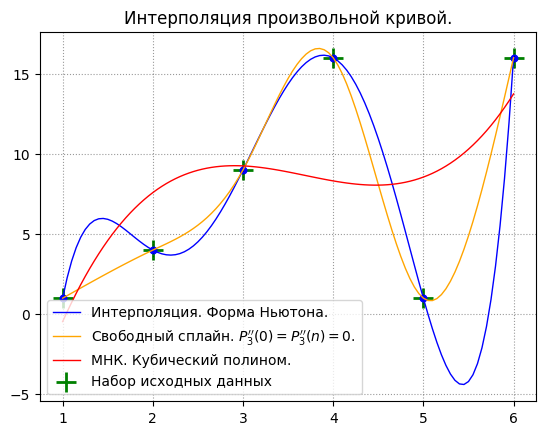

In [68]:
xdata = [1, 2, 3, 4, 5, 6]
ydata = [1, 4, 9, 16, 1, 16]

interp_range = slice(0, len(xdata))
interp_x = numpy.array(xdata[interp_range])
interp_y = numpy.array(ydata[interp_range])

spl = NewtonInterpolant(interp_x, interp_y)
spl1 = Spline(interp_x, interp_y)
mls = MLS(interp_x, interp_y)

plt.title("Интерполяция произвольной кривой.")

maxd = max(interp_x)
mind = min(interp_x)
x = numpy.arange(mind, maxd, (maxd - mind) / 100)
interpx = [mind] + list(x) + [maxd]
interpy = numpy.array([spl.Interpolate(_x) for _x in interpx])
plt.plot(interpx, interpy, c="blue",linewidth=1, label="Интерполяция. Форма Ньютона.")

interpy1 = numpy.array([spl1.Interpolate(_x) for _x in interpx])
plt.plot(interpx, interpy1, c="orange",linewidth=1, label="Свободный сплайн. $P_3''(0) = P_3''(n) = 0.$")

interpy2 = numpy.array([mls.Interpolate(_x) for _x in interpx])
plt.plot(interpx, interpy2, c="red",linewidth=1, label="МНК. Кубический полином.")

plt.scatter(xdata, ydata, marker='+',linewidth=2, s=200, c="green", label="Набор исходных данных")

interp = numpy.array([spl.Interpolate(x) for x in interp_x])
plt.scatter(interp_x, interp, marker='.',s=90, c="blue")

plt.legend()
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.show()

### Синус

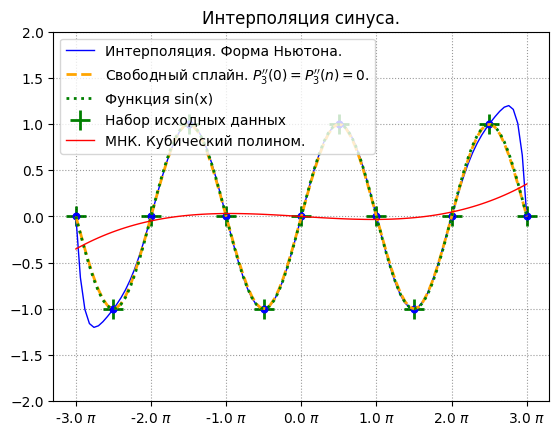

In [69]:
xdata = numpy.arange(-3 * math.pi, 3 * math.pi + 0.01, 0.5 * math.pi)
ydata = numpy.sin(xdata)

#interp_range = slice(1, len(xdata) - 1)
interp_range = slice(0, len(xdata))
interp_x = numpy.array(xdata[interp_range])
interp_y = numpy.array(ydata[interp_range])

spl = NewtonInterpolant(interp_x, interp_y)

fig  = plt.figure()
axes = fig.add_subplot()
plt.title("Интерполяция синуса.")

maxd = max(interp_x)
mind = min(interp_x)
x = numpy.arange(mind, maxd, (maxd - mind) / 100)
interpx = [mind] + list(x) + [maxd]
interpy = numpy.array([spl.Interpolate(mind)] + [spl.Interpolate(_x) for _x in x] + [spl.Interpolate(maxd)])
plt.plot(interpx, interpy, c="blue",linewidth=1, label="Интерполяция. Форма Ньютона.")

spl1 = Spline(interp_x, interp_y)
interpy1 = numpy.array([spl1.Interpolate(_x) for _x in interpx])
plt.plot(interpx, interpy1, c="orange",linewidth=2,linestyle='--', label="Свободный сплайн. $P_3''(0) = P_3''(n) = 0.$")

plt.plot(interpx, numpy.sin(interpx), c="green",linewidth=2,linestyle=':', label="Функция sin(x)")
plt.scatter(xdata, ydata, marker='+',linewidth=2, s=200, c="green", label="Набор исходных данных")

mls = MLS(interp_x, interp_y)
interpy2 = numpy.array([mls.Interpolate(_x) for _x in interpx])
plt.plot(interpx, interpy2, c="red",linewidth=1, label="МНК. Кубический полином.")

interp = numpy.array([spl.Interpolate(x) for x in interp_x])
plt.scatter(interp_x, interp, marker='.',s=90, c="blue")

def xTickFormatter(tickVal, position):
    return "{:.1f} $\pi$".format(tickVal / math.pi)

axes.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(xTickFormatter))
axes.set_xticks(xdata[::2])
axes.set_yticks(numpy.arange(-2, 2.01, 0.5))
plt.legend()
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.show()

### Численность населения России

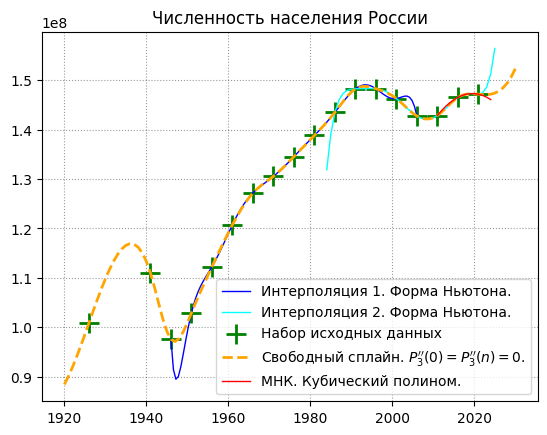

Численность населения России на 2023 год:
Точное значение = 146447424
Экстраполированное значение (интерполянт 2 в форме Ньютона) = 148599356
Погрешность 1.5%
Экстраполированное значение (свободный сплайн) = 147103198
Погрешность 0.4%
Экстраполированное значение (МНК, кубический полином) = 146582760
Погрешность 0.1%

Численность населения России на 1964 год (середина  между точками):
Точное значение = 125179206
Интерполированное значение (интерполянт 1 в форме Ньютона) = 125191930
Погрешность 0.010%
Интерполированное значение (свободный сплайн) = 125022657
Погрешность -0.1%


In [78]:
xdata = data["x"]
ydata = data["y"]

interp_range = slice(2, len(xdata) - 3)
interp_x = numpy.array(xdata[interp_range])
interp_y = numpy.array(ydata[interp_range])

spl = NewtonInterpolant(interp_x, interp_y)

interp_range2 = slice(10, len(xdata))
interp_x2 = numpy.array(xdata[interp_range2])
interp_y2 = numpy.array(ydata[interp_range2])

spl2 = NewtonInterpolant(interp_x2, interp_y2)

plt.title("Численность населения России")

maxd = max(interp_x)
mind = min(interp_x)
x = numpy.arange(mind, maxd, (maxd - mind) / 100)
interpx = [mind] + list(x) + [maxd]
interpy = numpy.array([spl.Interpolate(mind)] + [spl.Interpolate(_x) for _x in x] + [spl.Interpolate(maxd)])
plt.plot(interpx, interpy, c="blue",linewidth=1, label="Интерполяция 1. Форма Ньютона.")

maxd = max(interp_x2)
maxd = 2023
mind = min(interp_x2)
interpx = numpy.arange(mind - 2, 2025.01, 1)
interpy = numpy.array([spl2.Interpolate(_x) for _x in interpx])
plt.plot(interpx, interpy, c="cyan",linewidth=1, label="Интерполяция 2. Форма Ньютона.")

plt.scatter(xdata, ydata, marker='+',linewidth=2, s=200, c="green", label="Набор исходных данных")

spl1 = Spline(xdata, ydata)
interpx2 = numpy.arange(1920, 2030.01, 1)
interpy1 = numpy.array([spl1.Interpolate(_x) for _x in interpx2])
plt.plot(interpx2, interpy1, c="orange",linewidth=2,linestyle='--', label="Свободный сплайн. $P_3''(0) = P_3''(n) = 0.$")

interp = numpy.array([spl.Interpolate(x) for x in interp_x])

interp_range3 = slice(15, len(xdata))
interp_x3 = numpy.array(xdata[interp_range3])
interp_y3 = numpy.array(ydata[interp_range3])

mls = MLS(interp_x3, interp_y3)
int3 = numpy.arange(min(interp_x3), 2025, 1)
interpy2 = numpy.array([mls.Interpolate(_x) for _x in int3])
plt.plot(int3, interpy2, c="red",linewidth=1, label="МНК. Кубический полином.")

# plt.scatter(interp_x, interp, marker='.',s=90, c="blue")

plt.legend()
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.show()

print("Численность населения России на 2023 год:")
a1 = 146447424
a2 = int(spl2.Interpolate(2023))
a3 = int(spl1.Interpolate(2023))
a4 = int(mls.Interpolate(2023))
print("Точное значение = {:d}".format(a1))
print("Экстраполированное значение (интерполянт 2 в форме Ньютона) = {:d}".format(a2))
print("Погрешность {:.1f}%".format((a2 - a1) / a1 * 100))
print("Экстраполированное значение (свободный сплайн) = {:d}".format(a3))
print("Погрешность {:.1f}%".format((a3 - a1) / a1 * 100))
print("Экстраполированное значение (МНК, кубический полином) = {:d}".format(a4))
print("Погрешность {:.1f}%".format((a4 - a1) / a1 * 100))

print("\nЧисленность населения России на 1964 год (середина  между точками):")
a1 = 125179206
a2 = int(spl.Interpolate(1964))
a3 = int(spl1.Interpolate(1964))
print("Точное значение = {:d}".format(a1))
print("Интерполированное значение (интерполянт 1 в форме Ньютона) = {:d}".format(a2))
print("Погрешность {:.3f}%".format((a2 - a1) / a1 * 100))
print("Интерполированное значение (свободный сплайн) = {:d}".format(a3))
print("Погрешность {:.1f}%".format((a3 - a1) / a1 * 100))